Juliet Holmes mh3kh@virginia.edu

DS 5001

August 2022

# 6: Principal Component Analysis

The purpose of this notebook is to implement PCA from scratch to explore the data.

---

dependencies: BOW-F4.csv, LIB-F3.csv, VOCAB-F4.csv, TFIDF-F4.csv, DOC-F4.csv

output: PCA-DCM.csv, PCA_Loadings.csv, PCA-ComponentInfo.csv

code files referenced: M07_01_PCA.ipynb, M07_01_PCA-REVISED.ipynb

---
---

In [1]:
norm_docs = True # L2 norming
center_by_mean = False 
center_by_variance = False # Not supposed to ... Exaggerates significance of rare words
n_terms = 1000 # Number of significant words; feature space
#k = 6 # Number of components
k = 6

In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
from scipy.linalg import eigh
from sklearn.decomposition import PCA

from hac2 import HAC



In [3]:
# Importing the libraries
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import plotly_express as px
import seaborn as sns; sns.set()
pd.set_option('display.max_rows', 1000)  # or 1000

# Prepare data

In [5]:
BOW = pd.read_csv("BOW-F4.csv").set_index(["doc_id", "doc_title"])

In [6]:
BOW

term_str    n     tfidf
doc_id doc_title                                                    
0      Abstract data type                        1974  1.0  0.072767
       Abstract data type                          32  1.0  0.073347
       Abstract data type                    abstract  5.0  0.282039
       Abstract data type               abstract data  2.0  0.142374
       Abstract data type          abstract data type  2.0  0.150581
...                                               ...  ...       ...
4589   JavaScript InfoVis Toolkit               tools  1.0  0.089121
       JavaScript InfoVis Toolkit               trees  3.0  0.284750
       JavaScript InfoVis Toolkit       visualization  2.0  0.181003
       JavaScript InfoVis Toolkit      visualizations  3.0  0.379171
       JavaScript InfoVis Toolkit                 web  1.0  0.085357

[212028 rows x 3 columns]

In [7]:
LIB = pd.read_csv("LIB-F3.csv").set_index(["doc_title"])

In [8]:
VOCAB = pd.read_csv("VOCAB-F4.csv").set_index("term_str")

In [9]:
VOCAB

term_rank     n  n_chars  n_tokens  tfidf_mean    df  \
term_str                                                                 
data                      1  4996        4         1    0.037863  1484   
used                      2  2587        4         1    0.020109  1686   
distribution              3  1923       12         1    0.023496   538   
function                  4  1755        8         1    0.020344   740   
information               5  1663       11         1    0.018300   750   
...                     ...   ...      ...       ...         ...   ...   
chemical               3996    16        8         1    0.000404    13   
squared error          3997    16       13         2    0.000421    13   
pattern matching       3998    16       16         2    0.000442    12   
vapnik                 3999    16        6         1    0.000388     9   
stand                  4000    16        5         1    0.000405    16   

                        dfidf         p          i         h  ...  n_pos  \
term_str                                                      ...          
data              2416.974053  0.016115   5.955416  0.095974  ...   10.0   
used              2435.553906  0.008345   6.904910  0.057620  ...    3.0   
distribution      1663.765930  0.006203   7.332831  0.045485  ...    2.0   
function          1948.111147  0.005661   7.464719  0.042258  ...    5.0   
information       1959.912980  0.005364   7.542401  0.040460  ...    2.0   
...                       ...       ...        ...       ...  ...    ...   
chemical           110.025817  0.000052  14.241974  0.000735  ...    2.0   
squared error      110.025817  0.000052  14.241974  0.000735  ...    NaN   
pattern matching   102.948019  0.000052  14.241974  0.000735  ...    NaN   
vapnik              80.946352  0.000052  14.241974  0.000735  ...    1.0   
stand              130.623425  0.000052  14.241974  0.000735  ...    3.0   

                                                            cat_pos  \
term_str                                                              
data              {'VBZ', 'NN', 'FW', 'JJ', 'NNP', 'VB', 'VBN', ...   
used                                           {'VBD', 'JJ', 'VBN'}   
distribution                                          {'NNP', 'NN'}   
function                           {'NN', 'JJ', 'NNP', 'VB', 'VBP'}   
information                                           {'NNP', 'NN'}   
...                                                             ...   
chemical                                              {'NNP', 'NN'}   
squared error                                                   NaN   
pattern matching                                                NaN   
vapnik                                                      {'NNP'}   
stand                                           {'NN', 'VB', 'VBP'}   

                    stem_porter  stem_snowball    stem_lancaster  \
term_str                                                           
data                       data           data               dat   
used                        use            use                us   
distribution          distribut      distribut         distribut   
function               function       function             funct   
information              inform         inform            inform   
...                         ...            ...               ...   
chemical                 chemic         chemic              chem   
squared error     squared error  squared error     squared error   
pattern matching  pattern match  pattern match  pattern matching   
vapnik                   vapnik         vapnik            vapnik   
stand                     stand          stand             stand   

                             lemma stop term_rank2  zipf_k  zipf_k2  
term_str                                                             
data                          data    0          1    4996     4996  
used                          used    0        

In [10]:
# keep non stop words only
VOCAB = VOCAB[VOCAB.stop==0]

In [11]:
VOCAB = VOCAB.dropna()

In [12]:
VOCAB

term_rank     n  n_chars  n_tokens  tfidf_mean    df  \
term_str                                                             
data                  1  4996        4         1    0.037863  1484   
used                  2  2587        4         1    0.020109  1686   
distribution          3  1923       12         1    0.023496   538   
function              4  1755        8         1    0.020344   740   
information           5  1663       11         1    0.018300   750   
...                 ...   ...      ...       ...         ...   ...   
incorporate        3994    16       11         1    0.000333    15   
passes             3995    16        6         1    0.000292    13   
chemical           3996    16        8         1    0.000404    13   
vapnik             3999    16        6         1    0.000388     9   
stand              4000    16        5         1    0.000405    16   

                    dfidf         p          i         h  ...  n_pos  \
term_str                                                  ...          
data          2416.974053  0.016115   5.955416  0.095974  ...   10.0   
used          2435.553906  0.008345   6.904910  0.057620  ...    3.0   
distribution  1663.765930  0.006203   7.332831  0.045485  ...    2.0   
function      1948.111147  0.005661   7.464719  0.042258  ...    5.0   
information   1959.912980  0.005364   7.542401  0.040460  ...    2.0   
...                   ...       ...        ...       ...  ...    ...   
incorporate    123.856102  0.000052  14.241974  0.000735  ...    3.0   
passes         110.025817  0.000052  14.241974  0.000735  ...    2.0   
chemical       110.025817  0.000052  14.241974  0.000735  ...    2.0   
vapnik          80.946352  0.000052  14.241974  0.000735  ...    1.0   
stand          130.623425  0.000052  14.241974  0.000735  ...    3.0   

                                                        cat_pos  stem_porter  \
term_str                                                                       
data          {'VBZ', 'NN', 'FW', 'JJ', 'NNP', 'VB', 'VBN', ...         data   
used                                       {'VBD', 'JJ', 'VBN'}          use   
distribution                                      {'NNP', 'NN'}    distribut   
function                       {'NN', 'JJ', 'NNP', 'VB', 'VBP'}     function   
information                                       {'NNP', 'NN'}       inform   
...                                                         ...          ...   
incorporate                                 {'VB', 'JJ', 'VBP'}     incorpor   
passes                                           {'NNS', 'VBZ'}         pass   
chemical                                          {'NNP', 'NN'}       chemic   
vapnik                                                  {'NNP'}       vapnik   
stand                                       {'NN', 'VB', 'VBP'}        stand   

             stem_snowball stem_lancaster         lemma stop term_rank2  \
term_str                                                                  
data                  data            dat          data    0          1   
used                   use             us          used    0          2   
distribution     distribut      distribut  distribution    0          3   
function          function          funct      function    0          4   
information         inform         inform   information    0          5   
...                    ...            ...           ...  ...        ...   
incorporate       incorpor         incorp   incorporate    0        388   
passes                pass           pass          pass    0        388   
chemical            chemic           chem      chemical    0        388   
vapnik              vapnik         vapnik        vapnik    0        388   
stand                stand          stand         stand    0        388   

              zipf_k  zipf_k2  
term_str                       
data            4996     4996  
used            5174     5174  
distribution    5769 

In [13]:
TFIDF = pd.read_csv("TFIDF-F4.csv").set_index(["doc_id", "doc_title"])

In [14]:
TFIDF

000   10  100   11   12   13   14  \
doc_id doc_title                                                            
0      Abstract data type               0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      Associative array                0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      Augmented map                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      Cardinal tree                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      Collection (abstract data type)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                     ...  ...  ...  ...  ...  ...  ...   
4585   Variable shadowing               0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4586   Volatile (computer programming)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4587   Google Chart API                 0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4588   Google Charts                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4589   JavaScript InfoVis Toolkit       0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         15  1948  1949  ...  www   x1   x2  \
doc_id doc_title                                         ...                  
0      Abstract data type               0.0   0.0   0.0  ...  0.0  0.0  0.0   
1      Associative array                0.0   0.0   0.0  ...  0.0  0.0  0.0   
2      Augmented map                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
3      Cardinal tree                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
4      Collection (abstract data type)  0.0   0.0   0.0  ...  0.0  0.0  0.0   
...                                     ...   ...   ...  ...  ...  ...  ...   
4585   Variable shadowing               0.0   0.0   0.0  ...  0.0  0.0  0.0   
4586   Volatile (computer programming)  0.0   0.0   0.0  ...  0.0  0.0  0.0   
4587   Google Chart API                 0.0   0.0   0.0  ...  0.0  0.0  0.0   
4588   Google Charts                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
4589   JavaScript InfoVis Toolkit       0.0   0.0   0.0  ...  0.0  0.0  0.0   

                                        xml  year  years  yes  yield  yields  \
doc_id doc_title                                                               
0      Abstract data type               0.0   0.0    0.0  0.0    0.0     0.0   
1      Associative array                0.0   0.0    0.0  0.0    0.0     0.0   
2      Augmented map                    0.0   0.0    0.0  0.0    0.0     0.0   
3      Cardinal tree                    0.0   0.0    0.0  0.0    0.0     0.0   
4      Collection (abstract data type)  0.0   0.0    0.0  0.0    0.0     0.0   
...                                     ...   ...    ...  ...    ...     ...   
4585   Variable shadowing               0.0   0.0    0.0  0.0    0.0     0.0   
4586   Volatile (computer programming)  0.0   0.0    0.0  0.0    0.0     0.0   
4587   Google Chart API                 0.0   0.0    0.0  0.0    0.0     0.0   
4588   Google Charts                    0.0   0.0    0.0  0.0    0.0     0.0   
4589   JavaScript InfoVis Toolkit       0.0   0.0    0.0  0.0    0.0     0.0   

                                            zero  
doc_id doc_title                                  
0      Abstract data type               0.000000  
1      Associative array                0.000000  
2      Augmented map                    0.000000  
3      Cardinal tree                    0.000000  
4      Collection (abstract data type)  0.083672  
...                                          ...  
4585   Variable shadowing               0.000000  
4586   Volatile (computer programming)  0.000000  
4587   Google Chart API                 0.000000  
4588   Google Charts                    0.000000  
4589   JavaScript InfoVis Toolkit       0.000000  

[4589 rows x 4000 columns]

## LIB

In [15]:
categories = LIB["categories"].str.split('|', expand=True)

In [16]:
LIB

doc_id  \
doc_title                                 
Abstract data type                    0   
Associative array                     1   
Augmented map                         2   
Cardinal tree                         3   
Collection (abstract data type)       4   
...                                 ...   
Variable shadowing                 4585   
Volatile (computer programming)    4586   
Google Chart API                   4587   
Google Charts                      4588   
JavaScript InfoVis Toolkit         4589   

                                                                           doc_url  \
doc_title                                                                            
Abstract data type                https://en.wikipedia.org/wiki/Abstract_data_type   
Associative array                  https://en.wikipedia.org/wiki/Associative_array   
Augmented map                          https://en.wikipedia.org/wiki/Augmented_map   
Cardinal tree                          https://en.wikipedia.org/wiki/Cardinal_tree   
Collection (abstract data type)  https://en.wikipedia.org/wiki/Collection_(abst...   
...                                                                            ...   
Variable shadowing                https://en.wikipedia.org/wiki/Variable_shadowing   
Volatile (computer programming)  https://en.wikipedia.org/wiki/Volatile_(comput...   
Google Chart API                    https://en.wikipedia.org/wiki/Google_Chart_API   
Google Charts                          https://en.wikipedia.org/wiki/Google_Charts   
JavaScript InfoVis Toolkit       https://en.wikipedia.org/wiki/JavaScript_InfoV...   

                                                                       doc_summary  \
doc_title                                                                            
Abstract data type               <p>In computer science, an <b>abstract data ty...   
Associative array                <link rel="mw-deduplicated-inline-style" href=...   
Augmented map                    <p>In computer science, the <b>augmented map</...   
Cardinal tree                    <p>A <b>cardinal tree</b> (or trie) of degree ...   
Collection (abstract data type)  <p>In computer programming, a <b>collection</b...   
...                                                                            ...   
Variable shadowing               <p>In computer programming, <b>variable shadow...   
Volatile (computer programming)  <p><br>\nIn computer programming, particularly...   
Google Chart API                 <p>The <b>Google Chart API</b> is an interacti...   
Google Charts                    <p><b>Google Charts</b> is an interactive Web ...   
JavaScript InfoVis Toolkit       <p>The <b>JavaScript InfoVis Toolkit</b> provi...   

                                                                       doc_content  \
doc_title                                                                            
Abstract data type               <p>In computer science, an <b>abstract data ty...   
Associative array                <link rel="mw-deduplicated-inline-style" href=...   
Augmented map                    <p>In computer science, the <b>augmented map</...   
Cardinal tree                    <p>A <b>cardinal tree</b> (or trie) of degree ...   
Collection (abstract data type)  <p>In computer programming, a <b>collection</b...   
...                                                                            ...   
Variable shadowing               <p>In computer programming, <b>variable shadow...   
Volatile (computer programming)  <p><br>\nIn computer programming, particularly...   
Google Chart API                 <p>The <b>Google Chart API</b> is an interacti...   
Google Charts                    <p><b>Google Charts</b> is an interactive Web ...   
JavaScript InfoVis Toolkit       <p>The <b>JavaScript InfoVis Toolkit</b> provi...   

                                                  categories  \
doc_title                                           

In [17]:
cat_list = ["cat_1", "cat_2", "cat_3", "cat_4", "cat_5", "cat_6", "cat_7", "cat_8"]

In [18]:
categories.columns = cat_list

In [19]:
categories.count()

cat_1    4589
cat_2     701
cat_3     146
cat_4      38
cat_5       5
cat_6       3
cat_7       1
cat_8       1
dtype: int64

In [20]:
len(categories)

4589

In [21]:
#add course categorization to cat_1

In [22]:
cat_course_crosswalk = pd.read_csv("Category_Course_Crosswalk.csv")

In [23]:
cat_course_crosswalk

Category Course_Primary  \
0                                  Abstract data types        DS-5100   
1                                Algorithmic inference        CS-5012   
2                               Analysis of algorithms        CS-5012   
3                           Artificial neural networks        DS-6050   
4                                Assignment operations        DS-5100   
5                         Basic concepts in set theory        CS-5012   
6                                  Bayesian estimation        DS-6040   
7                                   Bayesian inference        DS-6040   
8                                    Bayesian networks        DS-6040   
9                                  Bayesian statistics        DS-6040   
10                                        Binary trees        CS-5012   
11                                    Causal inference        DS-6030   
12                        Class (computer programming)        DS-5100   
13                           Classification algorithms        DS-6030   
14                                    Cluster analysis        DS-6030   
15                         Cluster analysis algorithms        DS-6030   
16                          Combinatorial optimization        CS-5012   
17                                    Comparison sorts        CS-5012   
18                                  Complexity classes        CS-5012   
19                     Computational complexity theory        CS-5012   
20                       Conjugate prior distributions        DS-6040   
21                                   Contingency table        DS-6030   
22                            Continuous distributions        DS-6040   
23                                        Control flow        DS-5100   
24                                  Corpus linguistics        DS-5001   
25                                       Data analysis        DS-6001   
26                                     Data management        DS-6001   
27           Data mining and machine learning software        DS-6030   
28                                  Data visualization      SARC-5400   
29                              Database normalization        DS-6001   
30                                       Deep learning        DS-6050   
31                                           Deepfakes        DS-6050   
32                                 Dimension reduction        DS-6001   
33                                 Dynamic programming        CS-5012   
34                                   Ensemble learning        DS-6030   
35                           Entity relationship model        DS-6001   
36                             Entropy and information        DS-6040   
37                             Estimation of densities        DS-6040   
38                                   Estimation theory        DS-6040   
39                           Exploratory data analysis        DS-6001   
40                    Exponential family distributions        DS-6040   
41                         Free data analysis software      SARC-5400   
42                    Free data visualization software      STAT-6021   
43              Free R (programming language) software      STAT-6021   
44                           Free statistical software          Other   
45                              Functions and mappings          Other   
46                                    Graphical models        DS-6040   
47                                   Greedy algorithms        CS-5012   
48                                             Hashing        CS-5012   
49                                Hidden Markov models        DS-6040   
50                                 Immediate inference        CS-5012   
51                   Independence (probability theory)        DS-6030   
52                                        Infographics      SARC-5400   
53                                Information geometry        DS-6040   
54                    Informati

In [24]:
categories = categories.merge(cat_course_crosswalk, left_on = "cat_1", right_on = "Category", how = 'left')

In [25]:
cat_subset = categories[["cat_1", "Course_Primary"]]

In [26]:
cat_subset

cat_1 Course_Primary
0             Abstract data types        DS-5100
1             Abstract data types        DS-5100
2             Abstract data types        DS-5100
3             Abstract data types        DS-5100
4             Abstract data types        DS-5100
...                           ...            ...
4584  Variable (computer science)        DS-5100
4585  Variable (computer science)        DS-5100
4586            Visualization API      SARC-5400
4587            Visualization API      SARC-5400
4588            Visualization API      SARC-5400

[4589 rows x 2 columns]

In [27]:
cat_subset.cat_1.value_counts(dropna = False)

Data management                                       306
Linear algebra                                        265
Machine learning                                      193
Artificial neural networks                            170
Information theory                                    166
Continuous distributions                              164
Natural language processing                           159
Functions and mappings                                123
Infographics                                          108
Data mining and machine learning software              97
Statistical charts and diagrams                        97
Computational complexity theory                        95
Search algorithms                                      89
Bayesian statistics                                    87
Complexity classes                                     87
Statistical deviation and dispersion                   74
Classification algorithms                              73
Regression ana

In [28]:
categories

cat_1 cat_2 cat_3 cat_4 cat_5 cat_6 cat_7 cat_8  \
0             Abstract data types  None  None  None  None  None  None  None   
1             Abstract data types  None  None  None  None  None  None  None   
2             Abstract data types  None  None  None  None  None  None  None   
3             Abstract data types  None  None  None  None  None  None  None   
4             Abstract data types  None  None  None  None  None  None  None   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
4584  Variable (computer science)  None  None  None  None  None  None  None   
4585  Variable (computer science)  None  None  None  None  None  None  None   
4586            Visualization API  None  None  None  None  None  None  None   
4587            Visualization API  None  None  None  None  None  None  None   
4588            Visualization API  None  None  None  None  None  None  None   

                         Category Course_Primary Course_Secondary  
0             Abstract data types        DS-5100              NaN  
1             Abstract data types        DS-5100              NaN  
2             Abstract data types        DS-5100              NaN  
3             Abstract data types        DS-5100              NaN  
4             Abstract data types        DS-5100              NaN  
...                           ...            ...              ...  
4584  Variable (computer science)        DS-5100              NaN  
4585  Variable (computer science)        DS-5100              NaN  
4586            Visualization API      SARC-5400              NaN  
4587            Visualization API      SARC-5400              NaN  
4588            Visualization API      SARC-5400              NaN  

[4589 rows x 11 columns]

In [29]:
DOC = pd.read_csv("DOC-F4.csv").set_index(["doc_id"])

In [30]:
DOC

doc_title  \
doc_id                                    
0                    Abstract data type   
1                     Associative array   
2                         Augmented map   
3                         Cardinal tree   
4       Collection (abstract data type)   
...                                 ...   
4585                 Variable shadowing   
4586    Volatile (computer programming)   
4587                   Google Chart API   
4588                      Google Charts   
4589         JavaScript InfoVis Toolkit   

                                                  doc_txt  n_tokens  \
doc_id                                                                
0       In computer science, an abstract data type (AD...       322   
1        In computer science, an associative array, ma...       188   
2       In computer science, the augmented map is an a...       111   
3       A cardinal tree (or trie) of degree k, by anal...        78   
4       In computer programming, a collection is a gro...       140   
...                                                   ...       ...   
4585    In computer programming, variable shadowing oc...       241   
4586     In computer programming, particularly in the ...       196   
4587    The Google Chart API is an interactive Web ser...       158   
4588    Google Charts is an interactive Web service th...        40   
4589    The JavaScript InfoVis Toolkit provides tools ...        95   

        tfidf_mean  n_tokens_used  token_use_rate  
doc_id                                             
0         0.002259          179.0        0.555901  
1         0.001794          119.0        0.632979  
2         0.000983           53.0        0.477477  
3         0.000983           27.0        0.346154  
4         0.001764           81.0        0.578571  
...            ...            ...             ...  
4585      0.001294          100.0        0.414938  
4586      0.001553           74.0        0.377551  
4587      0.001350           88.0        0.556962  
4588      0.001024           23.0        0.575000  
4589      0.001185           48.0        0.505263  

[4589 rows x 6 columns]

In [31]:
#DOC = DOC.drop('doc_id', axis = 1)

In [32]:
#add cat_1 from Lib table to DOC table

In [33]:
DOC["cat_1"] = cat_subset["cat_1"]

In [34]:
DOC

doc_title  \
doc_id                                    
0                    Abstract data type   
1                     Associative array   
2                         Augmented map   
3                         Cardinal tree   
4       Collection (abstract data type)   
...                                 ...   
4585                 Variable shadowing   
4586    Volatile (computer programming)   
4587                   Google Chart API   
4588                      Google Charts   
4589         JavaScript InfoVis Toolkit   

                                                  doc_txt  n_tokens  \
doc_id                                                                
0       In computer science, an abstract data type (AD...       322   
1        In computer science, an associative array, ma...       188   
2       In computer science, the augmented map is an a...       111   
3       A cardinal tree (or trie) of degree k, by anal...        78   
4       In computer programming, a collection is a gro...       140   
...                                                   ...       ...   
4585    In computer programming, variable shadowing oc...       241   
4586     In computer programming, particularly in the ...       196   
4587    The Google Chart API is an interactive Web ser...       158   
4588    Google Charts is an interactive Web service th...        40   
4589    The JavaScript InfoVis Toolkit provides tools ...        95   

        tfidf_mean  n_tokens_used  token_use_rate                        cat_1  
doc_id                                                                          
0         0.002259          179.0        0.555901          Abstract data types  
1         0.001794          119.0        0.632979          Abstract data types  
2         0.000983           53.0        0.477477          Abstract data types  
3         0.000983           27.0        0.346154          Abstract data types  
4         0.001764           81.0        0.578571          Abstract data types  
...            ...            ...             ...                          ...  
4585      0.001294          100.0        0.414938  Variable (computer science)  
4586      0.001553           74.0        0.377551            Visualization API  
4587      0.001350           88.0        0.556962            Visualization API  
4588      0.001024           23.0        0.575000            Visualization API  
4589      0.001185           48.0        0.505263                          NaN  

[4589 rows x 7 columns]

In [35]:
DOC["course_primary"]= categories["Course_Primary"]

In [36]:
DOC

doc_title  \
doc_id                                    
0                    Abstract data type   
1                     Associative array   
2                         Augmented map   
3                         Cardinal tree   
4       Collection (abstract data type)   
...                                 ...   
4585                 Variable shadowing   
4586    Volatile (computer programming)   
4587                   Google Chart API   
4588                      Google Charts   
4589         JavaScript InfoVis Toolkit   

                                                  doc_txt  n_tokens  \
doc_id                                                                
0       In computer science, an abstract data type (AD...       322   
1        In computer science, an associative array, ma...       188   
2       In computer science, the augmented map is an a...       111   
3       A cardinal tree (or trie) of degree k, by anal...        78   
4       In computer programming, a collection is a gro...       140   
...                                                   ...       ...   
4585    In computer programming, variable shadowing oc...       241   
4586     In computer programming, particularly in the ...       196   
4587    The Google Chart API is an interactive Web ser...       158   
4588    Google Charts is an interactive Web service th...        40   
4589    The JavaScript InfoVis Toolkit provides tools ...        95   

        tfidf_mean  n_tokens_used  token_use_rate  \
doc_id                                              
0         0.002259          179.0        0.555901   
1         0.001794          119.0        0.632979   
2         0.000983           53.0        0.477477   
3         0.000983           27.0        0.346154   
4         0.001764           81.0        0.578571   
...            ...            ...             ...   
4585      0.001294          100.0        0.414938   
4586      0.001553           74.0        0.377551   
4587      0.001350           88.0        0.556962   
4588      0.001024           23.0        0.575000   
4589      0.001185           48.0        0.505263   

                              cat_1 course_primary  
doc_id                                              
0               Abstract data types        DS-5100  
1               Abstract data types        DS-5100  
2               Abstract data types        DS-5100  
3               Abstract data types        DS-5100  
4               Abstract data types        DS-5100  
...                             ...            ...  
4585    Variable (computer science)        DS-5100  
4586              Visualization API      SARC-5400  
4587              Visualization API      SARC-5400  
4588              Visualization API      SARC-5400  
4589                            NaN            NaN  

[4589 rows x 8 columns]

In [37]:
DOC

doc_title  \
doc_id                                    
0                    Abstract data type   
1                     Associative array   
2                         Augmented map   
3                         Cardinal tree   
4       Collection (abstract data type)   
...                                 ...   
4585                 Variable shadowing   
4586    Volatile (computer programming)   
4587                   Google Chart API   
4588                      Google Charts   
4589         JavaScript InfoVis Toolkit   

                                                  doc_txt  n_tokens  \
doc_id                                                                
0       In computer science, an abstract data type (AD...       322   
1        In computer science, an associative array, ma...       188   
2       In computer science, the augmented map is an a...       111   
3       A cardinal tree (or trie) of degree k, by anal...        78   
4       In computer programming, a collection is a gro...       140   
...                                                   ...       ...   
4585    In computer programming, variable shadowing oc...       241   
4586     In computer programming, particularly in the ...       196   
4587    The Google Chart API is an interactive Web ser...       158   
4588    Google Charts is an interactive Web service th...        40   
4589    The JavaScript InfoVis Toolkit provides tools ...        95   

        tfidf_mean  n_tokens_used  token_use_rate  \
doc_id                                              
0         0.002259          179.0        0.555901   
1         0.001794          119.0        0.632979   
2         0.000983           53.0        0.477477   
3         0.000983           27.0        0.346154   
4         0.001764           81.0        0.578571   
...            ...            ...             ...   
4585      0.001294          100.0        0.414938   
4586      0.001553           74.0        0.377551   
4587      0.001350           88.0        0.556962   
4588      0.001024           23.0        0.575000   
4589      0.001185           48.0        0.505263   

                              cat_1 course_primary  
doc_id                                              
0               Abstract data types        DS-5100  
1               Abstract data types        DS-5100  
2               Abstract data types        DS-5100  
3               Abstract data types        DS-5100  
4               Abstract data types        DS-5100  
...                             ...            ...  
4585    Variable (computer science)        DS-5100  
4586              Visualization API      SARC-5400  
4587              Visualization API      SARC-5400  
4588              Visualization API      SARC-5400  
4589                            NaN            NaN  

[4589 rows x 8 columns]

In [38]:
DOC.course_primary.value_counts(dropna= False)

DS-6030      990
CS-5012      706
DS-6040      556
DS-5001      537
DS-6001      526
Other        462
DS-5100      251
DS-6050      233
SARC-5400    183
STAT-6021    140
NaN            5
Name: course_primary, dtype: int64

## Vocab

In [39]:
SIGS = VOCAB.sort_values('dfidf', ascending=False).head(n_terms).index

In [40]:
SIGS

Index(['used', 'data', 'set', 'theory', 'example', 'called', 'analysis',
       'statistics', 'information', 'function',
       ...
       'shannon', 'item', 'enterprise', 'handle', 'david', 'hierarchy',
       'reduced', 'label', 'corresponds', 'aspects'],
      dtype='object', name='term_str', length=1000)

In [41]:
print(SIGS)

Index(['used', 'data', 'set', 'theory', 'example', 'called', 'analysis',
       'statistics', 'information', 'function',
       ...
       'shannon', 'item', 'enterprise', 'handle', 'david', 'hierarchy',
       'reduced', 'label', 'corresponds', 'aspects'],
      dtype='object', name='term_str', length=1000)


In [42]:
SIGS[500]

'fundamental'

In [43]:
SIGS[3]

'theory'

In [44]:
VOCAB

term_rank     n  n_chars  n_tokens  tfidf_mean    df  \
term_str                                                             
data                  1  4996        4         1    0.037863  1484   
used                  2  2587        4         1    0.020109  1686   
distribution          3  1923       12         1    0.023496   538   
function              4  1755        8         1    0.020344   740   
information           5  1663       11         1    0.018300   750   
...                 ...   ...      ...       ...         ...   ...   
incorporate        3994    16       11         1    0.000333    15   
passes             3995    16        6         1    0.000292    13   
chemical           3996    16        8         1    0.000404    13   
vapnik             3999    16        6         1    0.000388     9   
stand              4000    16        5         1    0.000405    16   

                    dfidf         p          i         h  ...  n_pos  \
term_str                                                  ...          
data          2416.974053  0.016115   5.955416  0.095974  ...   10.0   
used          2435.553906  0.008345   6.904910  0.057620  ...    3.0   
distribution  1663.765930  0.006203   7.332831  0.045485  ...    2.0   
function      1948.111147  0.005661   7.464719  0.042258  ...    5.0   
information   1959.912980  0.005364   7.542401  0.040460  ...    2.0   
...                   ...       ...        ...       ...  ...    ...   
incorporate    123.856102  0.000052  14.241974  0.000735  ...    3.0   
passes         110.025817  0.000052  14.241974  0.000735  ...    2.0   
chemical       110.025817  0.000052  14.241974  0.000735  ...    2.0   
vapnik          80.946352  0.000052  14.241974  0.000735  ...    1.0   
stand          130.623425  0.000052  14.241974  0.000735  ...    3.0   

                                                        cat_pos  stem_porter  \
term_str                                                                       
data          {'VBZ', 'NN', 'FW', 'JJ', 'NNP', 'VB', 'VBN', ...         data   
used                                       {'VBD', 'JJ', 'VBN'}          use   
distribution                                      {'NNP', 'NN'}    distribut   
function                       {'NN', 'JJ', 'NNP', 'VB', 'VBP'}     function   
information                                       {'NNP', 'NN'}       inform   
...                                                         ...          ...   
incorporate                                 {'VB', 'JJ', 'VBP'}     incorpor   
passes                                           {'NNS', 'VBZ'}         pass   
chemical                                          {'NNP', 'NN'}       chemic   
vapnik                                                  {'NNP'}       vapnik   
stand                                       {'NN', 'VB', 'VBP'}        stand   

             stem_snowball stem_lancaster         lemma stop term_rank2  \
term_str                                                                  
data                  data            dat          data    0          1   
used                   use             us          used    0          2   
distribution     distribut      distribut  distribution    0          3   
function          function          funct      function    0          4   
information         inform         inform   information    0          5   
...                    ...            ...           ...  ...        ...   
incorporate       incorpor         incorp   incorporate    0        388   
passes                pass           pass          pass    0        388   
chemical            chemic           chem      chemical    0        388   
vapnik              vapnik         vapnik        vapnik    0        388   
stand                stand          stand         stand    0        388   

              zipf_k  zipf_k2  
term_str                       
data            4996     4996  
used            5174     5174  
distribution    5769 

## TFIDF

In [45]:
TFIDF

000   10  100   11   12   13   14  \
doc_id doc_title                                                            
0      Abstract data type               0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      Associative array                0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      Augmented map                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      Cardinal tree                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      Collection (abstract data type)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                     ...  ...  ...  ...  ...  ...  ...   
4585   Variable shadowing               0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4586   Volatile (computer programming)  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4587   Google Chart API                 0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4588   Google Charts                    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4589   JavaScript InfoVis Toolkit       0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         15  1948  1949  ...  www   x1   x2  \
doc_id doc_title                                         ...                  
0      Abstract data type               0.0   0.0   0.0  ...  0.0  0.0  0.0   
1      Associative array                0.0   0.0   0.0  ...  0.0  0.0  0.0   
2      Augmented map                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
3      Cardinal tree                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
4      Collection (abstract data type)  0.0   0.0   0.0  ...  0.0  0.0  0.0   
...                                     ...   ...   ...  ...  ...  ...  ...   
4585   Variable shadowing               0.0   0.0   0.0  ...  0.0  0.0  0.0   
4586   Volatile (computer programming)  0.0   0.0   0.0  ...  0.0  0.0  0.0   
4587   Google Chart API                 0.0   0.0   0.0  ...  0.0  0.0  0.0   
4588   Google Charts                    0.0   0.0   0.0  ...  0.0  0.0  0.0   
4589   JavaScript InfoVis Toolkit       0.0   0.0   0.0  ...  0.0  0.0  0.0   

                                        xml  year  years  yes  yield  yields  \
doc_id doc_title                                                               
0      Abstract data type               0.0   0.0    0.0  0.0    0.0     0.0   
1      Associative array                0.0   0.0    0.0  0.0    0.0     0.0   
2      Augmented map                    0.0   0.0    0.0  0.0    0.0     0.0   
3      Cardinal tree                    0.0   0.0    0.0  0.0    0.0     0.0   
4      Collection (abstract data type)  0.0   0.0    0.0  0.0    0.0     0.0   
...                                     ...   ...    ...  ...    ...     ...   
4585   Variable shadowing               0.0   0.0    0.0  0.0    0.0     0.0   
4586   Volatile (computer programming)  0.0   0.0    0.0  0.0    0.0     0.0   
4587   Google Chart API                 0.0   0.0    0.0  0.0    0.0     0.0   
4588   Google Charts                    0.0   0.0    0.0  0.0    0.0     0.0   
4589   JavaScript InfoVis Toolkit       0.0   0.0    0.0  0.0    0.0     0.0   

                                            zero  
doc_id doc_title                                  
0      Abstract data type               0.000000  
1      Associative array                0.000000  
2      Augmented map                    0.000000  
3      Cardinal tree                    0.000000  
4      Collection (abstract data type)  0.083672  
...                                          ...  
4585   Variable shadowing               0.000000  
4586   Volatile (computer programming)  0.000000  
4587   Google Chart API                 0.000000  
4588   Google Charts                    0.000000  
4589   JavaScript InfoVis Toolkit       0.000000  

[4589 rows x 4000 columns]

In [46]:
TFIDF[SIGS]

used      data       set   theory  \
doc_id doc_title                                                                
0      Abstract data type               0.022623  0.240655  0.060827  0.00000   
1      Associative array                0.000000  0.079938  0.000000  0.00000   
2      Augmented map                    0.000000  0.036041  0.000000  0.00000   
3      Cardinal tree                    0.000000  0.000000  0.077110  0.00000   
4      Collection (abstract data type)  0.000000  0.203220  0.000000  0.05289   
...                                          ...       ...       ...      ...   
4585   Variable shadowing               0.000000  0.000000  0.000000  0.00000   
4586   Volatile (computer programming)  0.036058  0.000000  0.000000  0.00000   
4587   Google Chart API                 0.000000  0.050474  0.000000  0.00000   
4588   Google Charts                    0.000000  0.076441  0.000000  0.00000   
4589   JavaScript InfoVis Toolkit       0.000000  0.040399  0.000000  0.00000   

                                         example  called  analysis  \
doc_id doc_title                                                     
0      Abstract data type               0.031595     0.0  0.031699   
1      Associative array                0.000000     0.0  0.000000   
2      Augmented map                    0.000000     0.0  0.000000   
3      Cardinal tree                    0.000000     0.0  0.000000   
4      Collection (abstract data type)  0.000000     0.0  0.000000   
...                                          ...     ...       ...   
4585   Variable shadowing               0.031291     0.0  0.000000   
4586   Volatile (computer programming)  0.000000     0.0  0.000000   
4587   Google Chart API                 0.033133     0.0  0.000000   
4588   Google Charts                    0.000000     0.0  0.000000   
4589   JavaScript InfoVis Toolkit       0.000000     0.0  0.000000   

                                        statistics  information  function  \
doc_id doc_title                                                            
0      Abstract data type                      0.0     0.000000  0.000000   
1      Associative array                       0.0     0.000000  0.035349   
2      Augmented map                           0.0     0.000000  0.286872   
3      Cardinal tree                           0.0     0.000000  0.000000   
4      Collection (abstract data type)         0.0     0.000000  0.000000   
...                                            ...          ...       ...   
4585   Variable shadowing                      0.0     0.000000  0.063238   
4586   Volatile (computer programming)         0.0     0.000000  0.000000   
4587   Google Chart API                        0.0     0.033321  0.000000   
4588   Google Charts                           0.0     0.100925  0.000000   
4589   JavaScript InfoVis Toolkit              0.0     0.053339  0.000000   

                                        ...  shannon  item  enterprise  \
doc_id doc_title                        ...                              
0      Abstract data type               ...      0.0   0.0         0.0   
1      Associative array                ...      0.0   0.0         0.0   
2      Augmented map                    ...      0.0   0.0         0.0   
3      Cardinal tree                    ...      0.0   0.0         0.0   
4      Collection (abstract data type)  ...      0.0   0.0         0.0   
...                                     ...      ...   ...         ...   
4585   Variable shadowing               ...      0.0   0.0         0.0   
4586   Volatile (computer programming)  ...      0.0   0.0         0.0   
4587   Google Chart API                 ...      0.0   0.0         0.0   
4588   Google Charts                    ...      0.0   0.0         0.0   
4589   JavaScript InfoVis Toolkit       ...      0.0   0.0         0.0   

                                        handle  david  hierarchy  reduced  \
doc_id doc_title                     

# Compute PCA

## Normalize doc vector lengths

We use TFIDF normalization, which scales documents by their pythagorean (Euclidean) length.

In [47]:
if norm_docs:
    print("L2 norming")
    TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0) # Euclidean norming

L2 norming


## Center term vectors

Note that we are taking the column-wise means -- the means for the term vectors. Also, we do this after normalizing the documents.

In [48]:
if center_by_mean:
    print("Centering by mean")
    TFIDF = TFIDF - TFIDF.mean()

## Normalize term vector variance

We do not normalize variance, which we would normally do, such as with data containing divergent units of measure. \ This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s–8m00s).

In [49]:
if center_by_variance:
    print("Centering by variance")
    TFIDF = TFIDF / TFIDF.std()

## Compute Covariance Matrix

In [50]:
COV = TFIDF.cov()

In [51]:
COV

000            10           100            11            12  \
000     2.654324e-04  1.383986e-05  5.507257e-05  1.244860e-05 -9.726385e-07   
10      1.383986e-05  3.189429e-04  1.057648e-05  6.608936e-05 -7.107650e-07   
100     5.507257e-05  1.057648e-05  1.577349e-04  2.132045e-05 -9.598418e-07   
11      1.244860e-05  6.608936e-05  2.132045e-05  1.986711e-04  6.176949e-05   
12     -9.726385e-07 -7.107650e-07 -9.598418e-07  6.176949e-05  2.321894e-04   
...              ...           ...           ...           ...           ...   
years   2.059284e-05  7.550351e-06  4.499805e-06  2.940886e-06 -1.392403e-06   
yes    -7.339551e-07 -1.195417e-06  7.948129e-07 -6.417496e-07 -5.733033e-07   
yield  -7.528435e-07 -1.226181e-06 -7.429386e-07 -6.582651e-07 -5.880574e-07   
yields -8.171311e-07 -1.330888e-06 -8.063804e-07  5.337384e-06  5.781701e-06   
zero   -5.980582e-07  1.890498e-06 -3.862815e-06  7.442474e-06  1.958594e-05   

                  13            14            15          1948          1949  \
000     3.541300e-06  8.600506e-06  4.602671e-06 -6.610080e-07 -4.419799e-07   
10     -4.286664e-07  9.581564e-06  1.435087e-05  7.140843e-06 -7.198671e-07   
100    -5.422867e-07 -6.007985e-07  2.408500e-06 -6.523114e-07 -4.361649e-07   
11      1.540413e-05 -5.323249e-07 -5.877902e-07 -5.779668e-07 -3.864547e-07   
12      3.671672e-05  1.780927e-06 -5.250990e-07 -5.163233e-07 -3.452371e-07   
...              ...           ...           ...           ...           ...   
years   5.894525e-06  1.272322e-05  1.759896e-06  1.695134e-06  1.585730e-06   
yes    -3.239021e-07 -3.588506e-07 -3.962408e-07 -3.896187e-07 -2.605167e-07   
yield  -3.322378e-07 -3.680856e-07 -4.064381e-07 -3.996455e-07 -2.672211e-07   
yields  6.495217e-06 -3.995176e-07 -4.411451e-07 -4.337725e-07 -2.900399e-07   
zero   -1.727428e-06 -1.913815e-06 -2.113223e-06 -2.077906e-06  1.139038e-08   

        ...           www            x1            x2           xml  \
000     ... -4.700208e-07 -6.324351e-07 -4.848219e-07 -3.080135e-08   
10      ... -7.655383e-07 -1.030068e-06 -7.896453e-07 -5.296801e-07   
100     ...  1.335047e-06 -6.241144e-07 -4.784433e-07  1.029697e-06   
11      ... -4.109730e-07 -5.529834e-07 -4.239146e-07 -1.203269e-06   
12      ... -3.671403e-07 -4.940045e-07 -3.787017e-07  1.613600e-06   
...     ...           ...           ...           ...           ...   
years   ...  2.061311e-06 -9.053771e-07 -6.940580e-07  5.582001e-07   
yes     ... -2.770449e-07 -3.727769e-07 -2.857691e-07 -8.111472e-07   
yield   ... -2.841746e-07 -3.823703e-07 -2.931234e-07 -6.920722e-07   
yields  ... -3.084412e-07 -4.150221e-07 -3.181541e-07 -9.030712e-07   
zero    ... -1.477530e-06 -1.988086e-06 -1.524058e-06 -4.226051e-06   

                year     years           yes         yield        yields  \
000     5.454753e-06  0.000021 -7.339551e-07 -7.528435e-07 -8.171311e-07   
10      1.036886e-05  0.000008 -1.195417e-06 -1.226181e-06 -1.330888e-06   
100    -5.870113e-07  0.000004  7.948129e-07 -7.429386e-07 -8.063804e-07   
11     -7.322191e-07  0.000003 -6.417496e-07 -6.582651e-07  5.337384e-06   
12      4.415190e-06 -0.000001 -5.733033e-07 -5.880574e-07  5.781701e-06   
...              ...       ...           ...           ...           ...   
years   1.290620e-05  0.000191  1.172150e-06 -1.077751e-06 -1.169783e-06   
yes    -8.089051e-07  0.000001  1.546044e-04 -4.437493e-07 -4.816425e-07   
yield  -8.297224e-07 -0.000001 -4.437493e-07  1.099934e-04  4.740856e-06   
yields -9.005750e-07 -0.000001 -4.816425e-07  4.740856e-06  1.089895e-04   
zero   -2.624660e-06 -0.000004  1.262085e-06 -2.259812e-06 -4.619044e-08   

                zero  
000    -5.980582e-07  
10      1.890498e-06  
100    -3.862815e-06  
11      7.442474e-06  
12      1.958594e-05  
...              ...  
years  -4.339233e-06  
yes     1.262085e-06  
yield  -2.259812e-06  
yields -4.619044e-08  
zero    5.199947e-04  

[4000 rows x 4000 columns]

## Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \ method eigh(), since our covarience matrix is symmetric.

Return values (from the docs):

    w(…, M) ndarray\ The eigenvalues in ascending order, each repeated according to its multiplicity.

    v{(…, M, M) ndarray, (…, M, M) matrix}\ The column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i]. Will return a matrix object if a is a matrix object.

    Eigenvalues are returned in ascending order.
    Eigenvectors are returned with columns sorted in the order of the eigenvalues.


In [52]:
w, v = eigh(COV, subset_by_index=(len(COV)-k,len(COV)-1))

In [53]:
v

array([[ 3.58251070e-03, -9.47646794e-03, -1.44473539e-03,
         1.86590122e-03,  4.09139816e-03,  4.16835841e-03],
       [ 4.38419422e-03, -5.93943445e-03,  1.46959400e-03,
        -1.79381383e-03, -7.05582404e-04,  2.61209550e-03],
       [ 4.00352878e-03, -2.70821685e-03, -4.79402188e-04,
         1.92993057e-03,  1.70175742e-03,  1.28954237e-03],
       ...,
       [ 1.36005725e-03,  2.74223017e-04, -1.02947863e-03,
        -2.15579309e-04,  4.54984499e-05, -1.30553719e-03],
       [-1.57548247e-03,  3.13255250e-03, -3.02026922e-03,
        -3.79472804e-03, -2.67844241e-03, -3.22685677e-04],
       [-2.33093568e-02,  8.10648995e-03, -1.74638215e-02,
        -2.26641094e-02, -1.33718244e-02, -2.45439779e-02]])

In [54]:
pc_ids = list(reversed([i for i in range(k)]))

In [55]:
C = pd.DataFrame(w, columns=['eig_val'])
C.index = pc_ids
C = C.sort_index()
C.index.name = 'pc_id'
C['exp_var'] = C.eig_val / C.eig_val.sum()

In [56]:
C

eig_val   exp_var
pc_id                    
0      0.011819  0.256044
1      0.008820  0.191060
2      0.007073  0.153217
3      0.006473  0.140232
4      0.006348  0.137518
5      0.005628  0.121928

In [57]:
eig_vals, eig_vecs = eigh(COV)

In [58]:
eig_vals

array([-8.15046438e-19, -2.12987927e-19, -1.81470243e-19, ...,
        7.07269653e-03,  8.81958271e-03,  1.18193184e-02])

In [59]:
eig_vecs

array([[-2.12080308e-14, -6.05207710e-16, -7.44899889e-16, ...,
         1.86590122e-03,  4.09139816e-03,  4.16835841e-03],
       [ 3.43711098e-15, -1.55626523e-15, -5.21492983e-16, ...,
        -1.79381383e-03, -7.05582404e-04,  2.61209550e-03],
       [ 4.16501851e-15, -3.30391642e-16, -3.62926366e-16, ...,
         1.92993057e-03,  1.70175742e-03,  1.28954237e-03],
       ...,
       [ 5.52130099e-15, -2.28211076e-15, -9.73046882e-16, ...,
        -2.15579309e-04,  4.54984499e-05, -1.30553719e-03],
       [-4.07318872e-15,  5.78289200e-17, -2.21132081e-16, ...,
        -3.79472804e-03, -2.67844241e-03, -3.22685677e-04],
       [ 9.84361620e-15,  1.47974914e-15, -5.05648917e-16, ...,
        -2.26641094e-02, -1.33718244e-02, -2.45439779e-02]])

In [60]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [61]:
EIG_VEC.head()

term_str           000            10           100            11  \
term_str                                                           
000      -2.120803e-14 -6.052077e-16 -7.448999e-16  2.589574e-15   
10        3.437111e-15 -1.556265e-15 -5.214930e-16 -2.040114e-17   
100       4.165019e-15 -3.303916e-16 -3.629264e-16 -1.928262e-15   
11       -4.852238e-15 -1.899600e-15 -8.264080e-16 -1.903428e-15   
12       -3.120438e-15 -5.488129e-16  4.738866e-16 -6.461354e-16   

term_str            12            13            14            15  \
term_str                                                           
000      -1.463781e-16 -1.472721e-15 -8.916637e-16  1.066742e-15   
10       -9.696697e-16 -8.851201e-17 -9.375074e-16 -9.360379e-16   
100      -2.119386e-15  2.332607e-15  1.600748e-15  6.360559e-16   
11        9.208851e-17  7.174941e-17  1.033040e-15  1.118198e-15   
12        1.402701e-15 -1.590377e-15  3.103408e-16  1.226782e-16   

term_str          1948          1949  ...       www        x1        x2  \
term_str                              ...                                 
000       0.000000e+00 -2.828989e-15  ... -0.003056  0.000623 -0.000949   
10       -5.463404e-17  2.775511e-15  ... -0.003674  0.000874  0.003646   
100       1.854479e-16  1.196782e-15  ...  0.001085  0.000519  0.000373   
11        2.070567e-15  1.194057e-15  ... -0.003071  0.000916 -0.002702   
12       -1.658695e-15  6.801488e-16  ... -0.002912  0.002160 -0.004911   

term_str       xml      year     years       yes     yield    yields      zero  
term_str                                                                        
000      -0.001826  0.003583 -0.009476  0.001445  0.001866  0.004091  0.004168  
10       -0.003453  0.004384 -0.005939 -0.001470 -0.001794 -0.000706  0.002612  
100      -0.000521  0.004004 -0.002708  0.000479  0.001930  0.001702  0.001290  
11       -0.004513  0.000110 -0.006366  0.003815 -0.004097  0.000099  0.001746  
12       -0.003168  0.001357 -0.004195  0.004505  0.001040  0.000706  0.001549  

[5 rows x 4000 columns]

In [62]:
EIG_VAL

eig_val
term_str              
000      -8.150464e-19
10       -2.129879e-19
100      -1.814702e-19
11       -1.347831e-19
12       -1.211711e-19
...                ...
years     6.348022e-03
yes       6.473291e-03
yield     7.072697e-03
yields    8.819583e-03
zero      1.181932e-02

[4000 rows x 1 columns]

## Pick top K components

In [63]:
EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k) #.index

In [64]:
COMPS = EIG_VEC[EIG_IDX.index].T # EIG_VEC.T.loc[EIG_IDX]
COMPS.index = [i for i in range(COMPS.shape[0])]
COMPS.index.name = 'pc_id'

In [65]:
COMPS

term_str       000        10       100        11        12        13  \
pc_id                                                                  
0         0.004168  0.002612  0.001290  0.001746  0.001549  0.001320   
1         0.004091 -0.000706  0.001702  0.000099  0.000706  0.000479   
2         0.001866 -0.001794  0.001930 -0.004097  0.001040 -0.000719   
3         0.001445 -0.001470  0.000479  0.003815  0.004505  0.001084   
4        -0.009476 -0.005939 -0.002708 -0.006366 -0.004195 -0.006050   
5         0.003583  0.004384  0.004004  0.000110  0.001357 -0.001214   

term_str        14        15      1948      1949  ...       www        x1  \
pc_id                                             ...                       
0         0.001763  0.002268 -0.002530 -0.001277  ...  0.000122 -0.002864   
1         0.000384  0.002128 -0.000337 -0.000287  ... -0.002076 -0.001286   
2        -0.001888  0.002514 -0.000713 -0.000901  ... -0.003313 -0.002756   
3         0.000365  0.001698 -0.000097 -0.000510  ...  0.002554  0.002600   
4        -0.006189 -0.004875 -0.002328 -0.002245  ...  0.000440 -0.000426   
5        -0.001838  0.001732  0.004140  0.002264  ... -0.004928  0.001357   

term_str        x2       xml      year     years       yes     yield  \
pc_id                                                                  
0        -0.000790  0.009010  0.002190  0.002501 -0.000141 -0.001306   
1        -0.002476  0.016659  0.005230  0.005684 -0.010551  0.000045   
2        -0.003292 -0.004826  0.000717  0.001074  0.001249 -0.000216   
3         0.003156 -0.006052  0.000051 -0.001559 -0.017587  0.001029   
4        -0.000947 -0.008623 -0.001849 -0.004765  0.005483  0.000274   
5        -0.002554 -0.009702  0.005268  0.007058  0.002469  0.001360   

term_str    yields      zero  
pc_id                         
0        -0.000323 -0.024544  
1        -0.002678 -0.013372  
2        -0.003795 -0.022664  
3         0.003020  0.017464  
4         0.003133  0.008106  
5        -0.001575 -0.023309  

[6 rows x 4000 columns]

In [66]:
C

eig_val   exp_var
pc_id                    
0      0.011819  0.256044
1      0.008820  0.191060
2      0.007073  0.153217
3      0.006473  0.140232
4      0.006348  0.137518
5      0.005628  0.121928

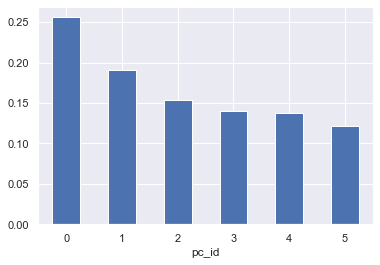

In [67]:
C.exp_var.plot.bar(rot=0);

# Define Loadings table
Loadings show the contribution of each term to the component

In [68]:
L = pd.DataFrame(v, index=COV.index)
L.columns = pc_ids
L = L.T.sort_index().T
L.columns.name = 'pc_id'

In [69]:
L

pc_id            0         1         2         3         4         5
term_str                                                            
000       0.004168  0.004091  0.001866 -0.001445 -0.009476  0.003583
10        0.002612 -0.000706 -0.001794  0.001470 -0.005939  0.004384
100       0.001290  0.001702  0.001930 -0.000479 -0.002708  0.004004
11        0.001746  0.000099 -0.004097 -0.003815 -0.006366  0.000110
12        0.001549  0.000706  0.001040 -0.004505 -0.004195  0.001357
...            ...       ...       ...       ...       ...       ...
years     0.002501  0.005684  0.001074  0.001559 -0.004765  0.007058
yes      -0.000141 -0.010551  0.001249  0.017587  0.005483  0.002469
yield    -0.001306  0.000045 -0.000216 -0.001029  0.000274  0.001360
yields   -0.000323 -0.002678 -0.003795 -0.003020  0.003133 -0.001575
zero     -0.024544 -0.013372 -0.022664 -0.017464  0.008106 -0.023309

[4000 rows x 6 columns]

# Create Component info table

In [70]:
COMPINF = pd.DataFrame(index=COMPS.index)
for i in range(k):
    for j in [0, 1]:
        top_terms = ' '.join(L.sort_values(i, ascending=bool(j)).head(5).index.to_list())
        COMPINF.loc[i, j] = top_terms

In [71]:
COMPINF

0  \
pc_id                                                     
0              data learning language software database   
1       data distribution database analysis information   
2      learning neural machine network machine learning   
3            complexity data problem algorithm problems   
4              data learning regression model algorithm   
5          regression variable variables model analysis   

                                                       1  
pc_id                                                     
0      distribution probability probability distribut...  
1         function complexity problem algorithm problems  
2                     matrix data function linear vector  
3                 neural matrix linear vector regression  
4             language sql natural language natural text  
5               function data matrix distribution vector

## Add Eigen Values and Explained Variance

In [72]:
COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()

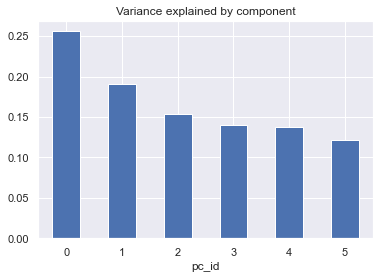

In [100]:
COMPINF.exp_var.sort_values(ascending=False).head(k).plot.bar(title = 'Variance explained by component', rot=0);

In [ ]:
COMPINF

# Create Document Component Table
We get the dot product of the DTM matrix and the new component matrix (as the loadings), which we will call DCM -- for document-component matrix. \ This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [77]:
DCM = TFIDF.dot(L)

In [78]:
DOC

doc_title  \
doc_id                                    
0                    Abstract data type   
1                     Associative array   
2                         Augmented map   
3                         Cardinal tree   
4       Collection (abstract data type)   
...                                 ...   
4585                 Variable shadowing   
4586    Volatile (computer programming)   
4587                   Google Chart API   
4588                      Google Charts   
4589         JavaScript InfoVis Toolkit   

                                                  doc_txt  n_tokens  \
doc_id                                                                
0       In computer science, an abstract data type (AD...       322   
1        In computer science, an associative array, ma...       188   
2       In computer science, the augmented map is an a...       111   
3       A cardinal tree (or trie) of degree k, by anal...        78   
4       In computer programming, a collection is a gro...       140   
...                                                   ...       ...   
4585    In computer programming, variable shadowing oc...       241   
4586     In computer programming, particularly in the ...       196   
4587    The Google Chart API is an interactive Web ser...       158   
4588    Google Charts is an interactive Web service th...        40   
4589    The JavaScript InfoVis Toolkit provides tools ...        95   

        tfidf_mean  n_tokens_used  token_use_rate  \
doc_id                                              
0         0.002259          179.0        0.555901   
1         0.001794          119.0        0.632979   
2         0.000983           53.0        0.477477   
3         0.000983           27.0        0.346154   
4         0.001764           81.0        0.578571   
...            ...            ...             ...   
4585      0.001294          100.0        0.414938   
4586      0.001553           74.0        0.377551   
4587      0.001350           88.0        0.556962   
4588      0.001024           23.0        0.575000   
4589      0.001185           48.0        0.505263   

                              cat_1 course_primary  
doc_id                                              
0               Abstract data types        DS-5100  
1               Abstract data types        DS-5100  
2               Abstract data types        DS-5100  
3               Abstract data types        DS-5100  
4               Abstract data types        DS-5100  
...                             ...            ...  
4585    Variable (computer science)        DS-5100  
4586              Visualization API      SARC-5400  
4587              Visualization API      SARC-5400  
4588              Visualization API      SARC-5400  
4589                            NaN            NaN  

[4589 rows x 8 columns]

In [79]:
DOC = DOC.reset_index()

In [80]:
DOC

doc_id                        doc_title  \
0          0               Abstract data type   
1          1                Associative array   
2          2                    Augmented map   
3          3                    Cardinal tree   
4          4  Collection (abstract data type)   
...      ...                              ...   
4584    4585               Variable shadowing   
4585    4586  Volatile (computer programming)   
4586    4587                 Google Chart API   
4587    4588                    Google Charts   
4588    4589       JavaScript InfoVis Toolkit   

                                                doc_txt  n_tokens  tfidf_mean  \
0     In computer science, an abstract data type (AD...       322    0.002259   
1      In computer science, an associative array, ma...       188    0.001794   
2     In computer science, the augmented map is an a...       111    0.000983   
3     A cardinal tree (or trie) of degree k, by anal...        78    0.000983   
4     In computer programming, a collection is a gro...       140    0.001764   
...                                                 ...       ...         ...   
4584  In computer programming, variable shadowing oc...       241    0.001294   
4585   In computer programming, particularly in the ...       196    0.001553   
4586  The Google Chart API is an interactive Web ser...       158    0.001350   
4587  Google Charts is an interactive Web service th...        40    0.001024   
4588  The JavaScript InfoVis Toolkit provides tools ...        95    0.001185   

      n_tokens_used  token_use_rate                        cat_1  \
0             179.0        0.555901          Abstract data types   
1             119.0        0.632979          Abstract data types   
2              53.0        0.477477          Abstract data types   
3              27.0        0.346154          Abstract data types   
4              81.0        0.578571          Abstract data types   
...             ...             ...                          ...   
4584          100.0        0.414938  Variable (computer science)   
4585           74.0        0.377551            Visualization API   
4586           88.0        0.556962            Visualization API   
4587           23.0        0.575000            Visualization API   
4588           48.0        0.505263                          NaN   

     course_primary  
0           DS-5100  
1           DS-5100  
2           DS-5100  
3           DS-5100  
4           DS-5100  
...             ...  
4584        DS-5100  
4585      SARC-5400  
4586      SARC-5400  
4587      SARC-5400  
4588            NaN  

[4589 rows x 9 columns]

In [81]:
DOC["label"] = DOC['doc_title']

In [82]:
DOC

doc_id                        doc_title  \
0          0               Abstract data type   
1          1                Associative array   
2          2                    Augmented map   
3          3                    Cardinal tree   
4          4  Collection (abstract data type)   
...      ...                              ...   
4584    4585               Variable shadowing   
4585    4586  Volatile (computer programming)   
4586    4587                 Google Chart API   
4587    4588                    Google Charts   
4588    4589       JavaScript InfoVis Toolkit   

                                                doc_txt  n_tokens  tfidf_mean  \
0     In computer science, an abstract data type (AD...       322    0.002259   
1      In computer science, an associative array, ma...       188    0.001794   
2     In computer science, the augmented map is an a...       111    0.000983   
3     A cardinal tree (or trie) of degree k, by anal...        78    0.000983   
4     In computer programming, a collection is a gro...       140    0.001764   
...                                                 ...       ...         ...   
4584  In computer programming, variable shadowing oc...       241    0.001294   
4585   In computer programming, particularly in the ...       196    0.001553   
4586  The Google Chart API is an interactive Web ser...       158    0.001350   
4587  Google Charts is an interactive Web service th...        40    0.001024   
4588  The JavaScript InfoVis Toolkit provides tools ...        95    0.001185   

      n_tokens_used  token_use_rate                        cat_1  \
0             179.0        0.555901          Abstract data types   
1             119.0        0.632979          Abstract data types   
2              53.0        0.477477          Abstract data types   
3              27.0        0.346154          Abstract data types   
4              81.0        0.578571          Abstract data types   
...             ...             ...                          ...   
4584          100.0        0.414938  Variable (computer science)   
4585           74.0        0.377551            Visualization API   
4586           88.0        0.556962            Visualization API   
4587           23.0        0.575000            Visualization API   
4588           48.0        0.505263                          NaN   

     course_primary                            label  
0           DS-5100               Abstract data type  
1           DS-5100                Associative array  
2           DS-5100                    Augmented map  
3           DS-5100                    Cardinal tree  
4           DS-5100  Collection (abstract data type)  
...             ...                              ...  
4584        DS-5100               Variable shadowing  
4585      SARC-5400  Volatile (computer programming)  
4586      SARC-5400                 Google Chart API  
4587      SARC-5400                    Google Charts  
4588            NaN       JavaScript InfoVis Toolkit  

[4589 rows x 10 columns]

In [83]:
DOC = DOC.set_index(['doc_id', 'doc_title'])

In [84]:
#DOC = DOC.drop('doc_id', axis = 1)

In [85]:
DOC

doc_txt  \
doc_id doc_title                                                                            
0      Abstract data type               In computer science, an abstract data type (AD...   
1      Associative array                 In computer science, an associative array, ma...   
2      Augmented map                    In computer science, the augmented map is an a...   
3      Cardinal tree                    A cardinal tree (or trie) of degree k, by anal...   
4      Collection (abstract data type)  In computer programming, a collection is a gro...   
...                                                                                   ...   
4585   Variable shadowing               In computer programming, variable shadowing oc...   
4586   Volatile (computer programming)   In computer programming, particularly in the ...   
4587   Google Chart API                 The Google Chart API is an interactive Web ser...   
4588   Google Charts                    Google Charts is an interactive Web service th...   
4589   JavaScript InfoVis Toolkit       The JavaScript InfoVis Toolkit provides tools ...   

                                        n_tokens  tfidf_mean  n_tokens_used  \
doc_id doc_title                                                              
0      Abstract data type                    322    0.002259          179.0   
1      Associative array                     188    0.001794          119.0   
2      Augmented map                         111    0.000983           53.0   
3      Cardinal tree                          78    0.000983           27.0   
4      Collection (abstract data type)       140    0.001764           81.0   
...                                          ...         ...            ...   
4585   Variable shadowing                    241    0.001294          100.0   
4586   Volatile (computer programming)       196    0.001553           74.0   
4587   Google Chart API                      158    0.001350           88.0   
4588   Google Charts                          40    0.001024           23.0   
4589   JavaScript InfoVis Toolkit             95    0.001185           48.0   

                                        token_use_rate  \
doc_id doc_title                                         
0      Abstract data type                     0.555901   
1      Associative array                      0.632979   
2      Augmented map                          0.477477   
3      Cardinal tree                          0.346154   
4      Collection (abstract data type)        0.578571   
...                                                ...   
4585   Variable shadowing                     0.414938   
4586   Volatile (computer programming)        0.377551   
4587   Google Chart API                       0.556962   
4588   Google Charts                          0.575000   
4589   JavaScript InfoVis Toolkit             0.505263   

                                                              cat_1  \
doc_id doc_title                                                      
0      Abstract data type                       Abstract data types   
1      Associative array                        Abstract data types   
2      Augmented map                            Abstract data types   
3      Cardinal tree                            Abstract data types   
4      Collection (abstract data type)          Abstract data types   
...                                                             ...   
4585   Variable shadowing               Variable (computer science)   
4586   Volatile (computer programming)            Visualization API   
4587   Google Chart API                           Visualization API   
4588   Google Charts                              Visualization API   
4589   JavaScript InfoVis Toolkit                               NaN   

                                       course_primary  \
doc_id doc_title                                        
0      Abstract data type                     DS-51

# DCM Scatterplots

In [86]:
try:
    DOC = DOC.join(DCM)
except:
    pass



In [87]:
DOC = DOC.dropna()

In [88]:
DOC.shape

(4582, 14)

## PC 0 and 1

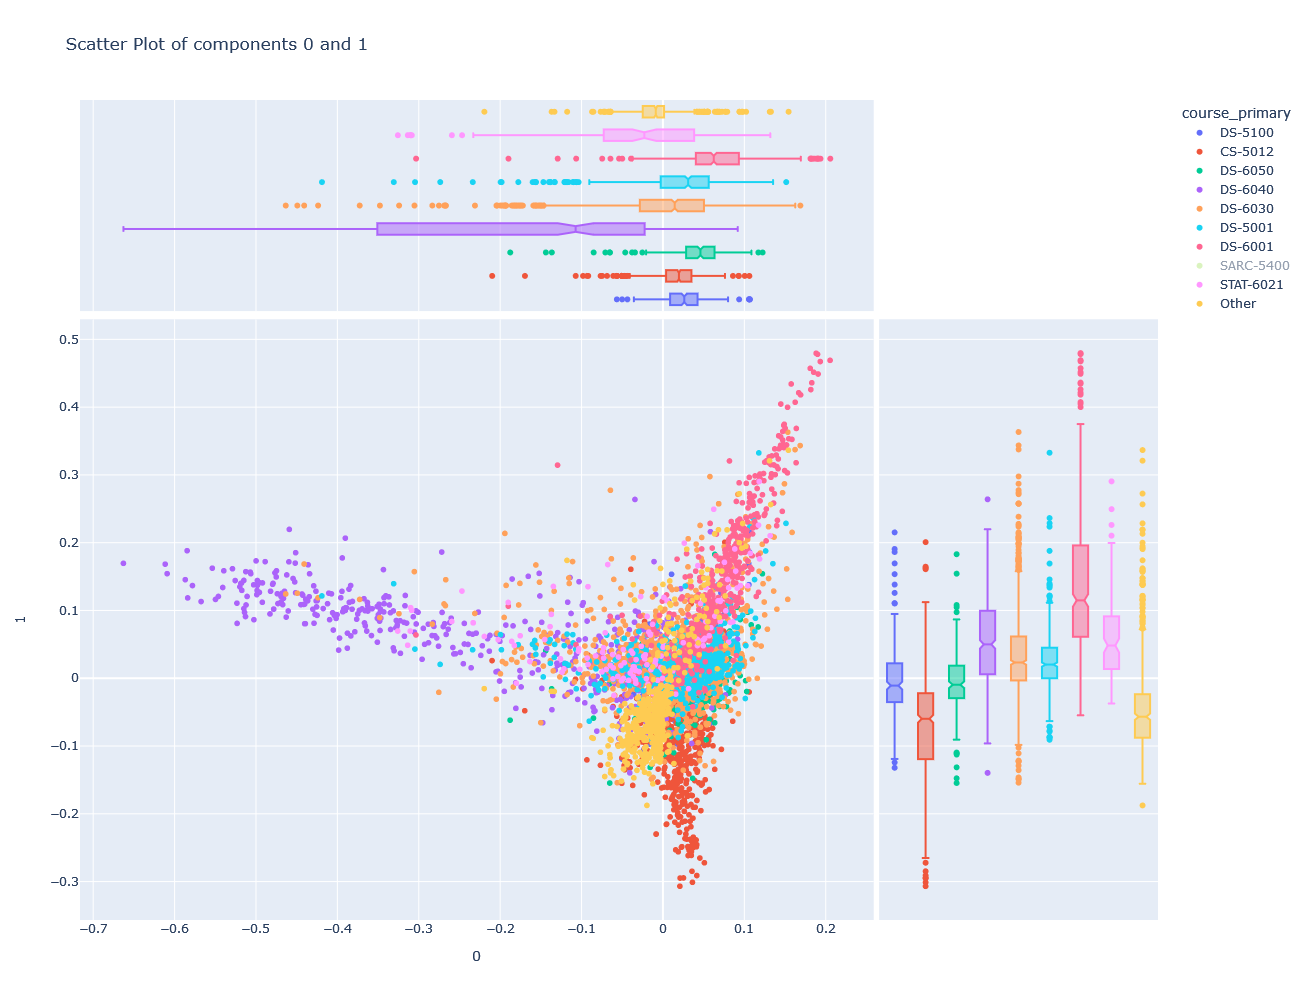

In [104]:
px.scatter(DOC, 0, 1, 
           color='course_primary', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000,
           title = 'Scatter Plot of components 0 and 1')



## PC 2 and 3

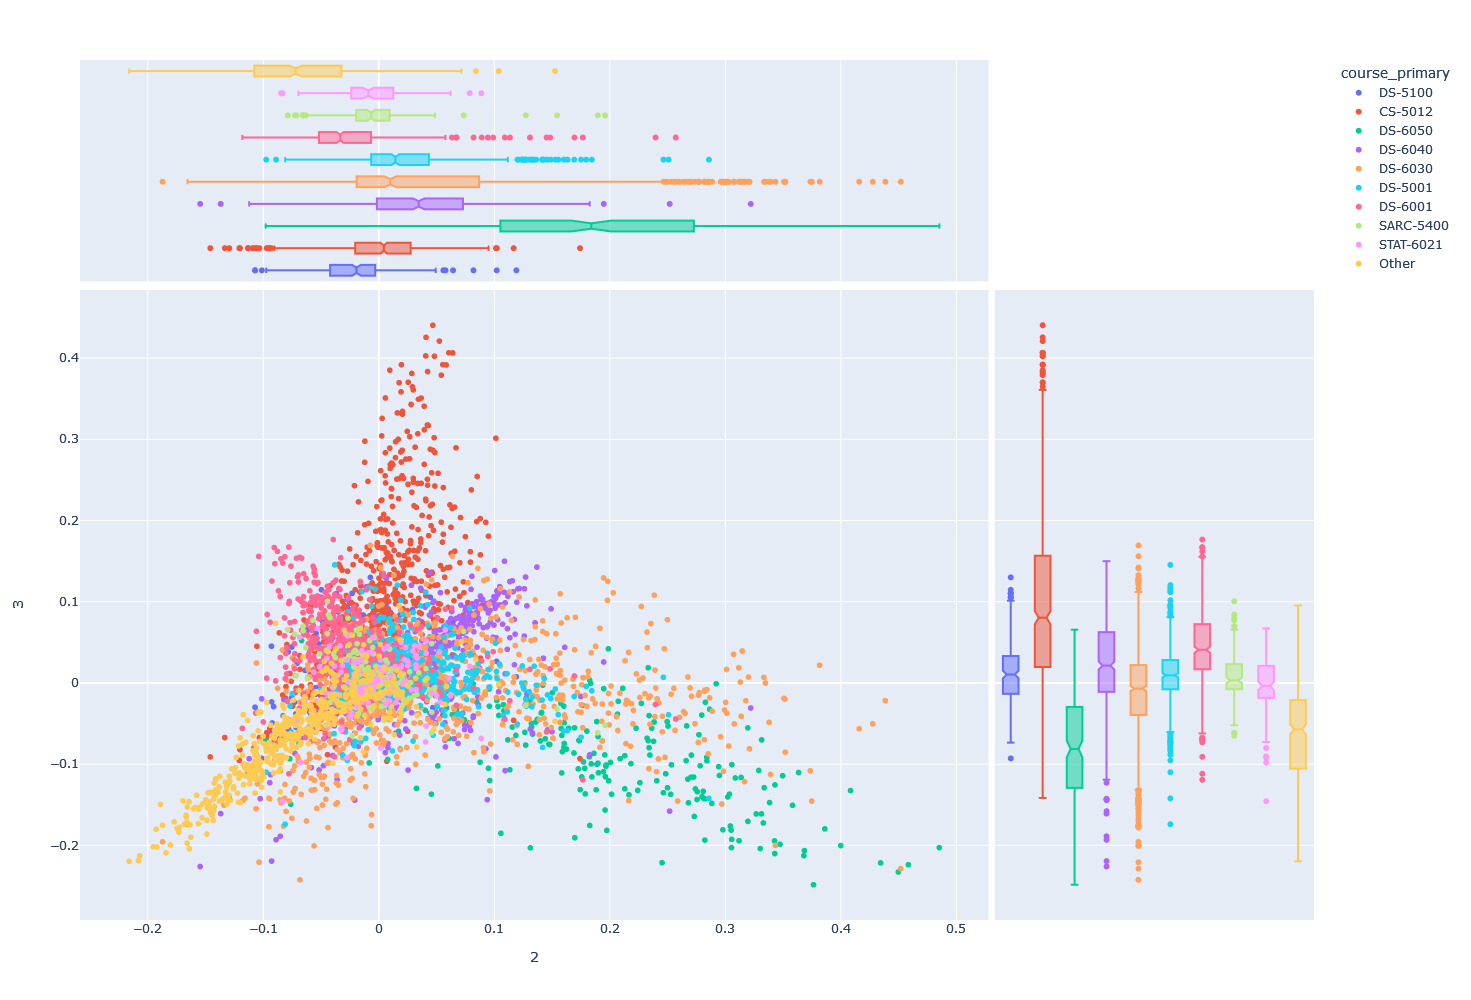

In [90]:
px.scatter(DOC, 2, 3, 
           color='course_primary', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)



## PC 4 and 5

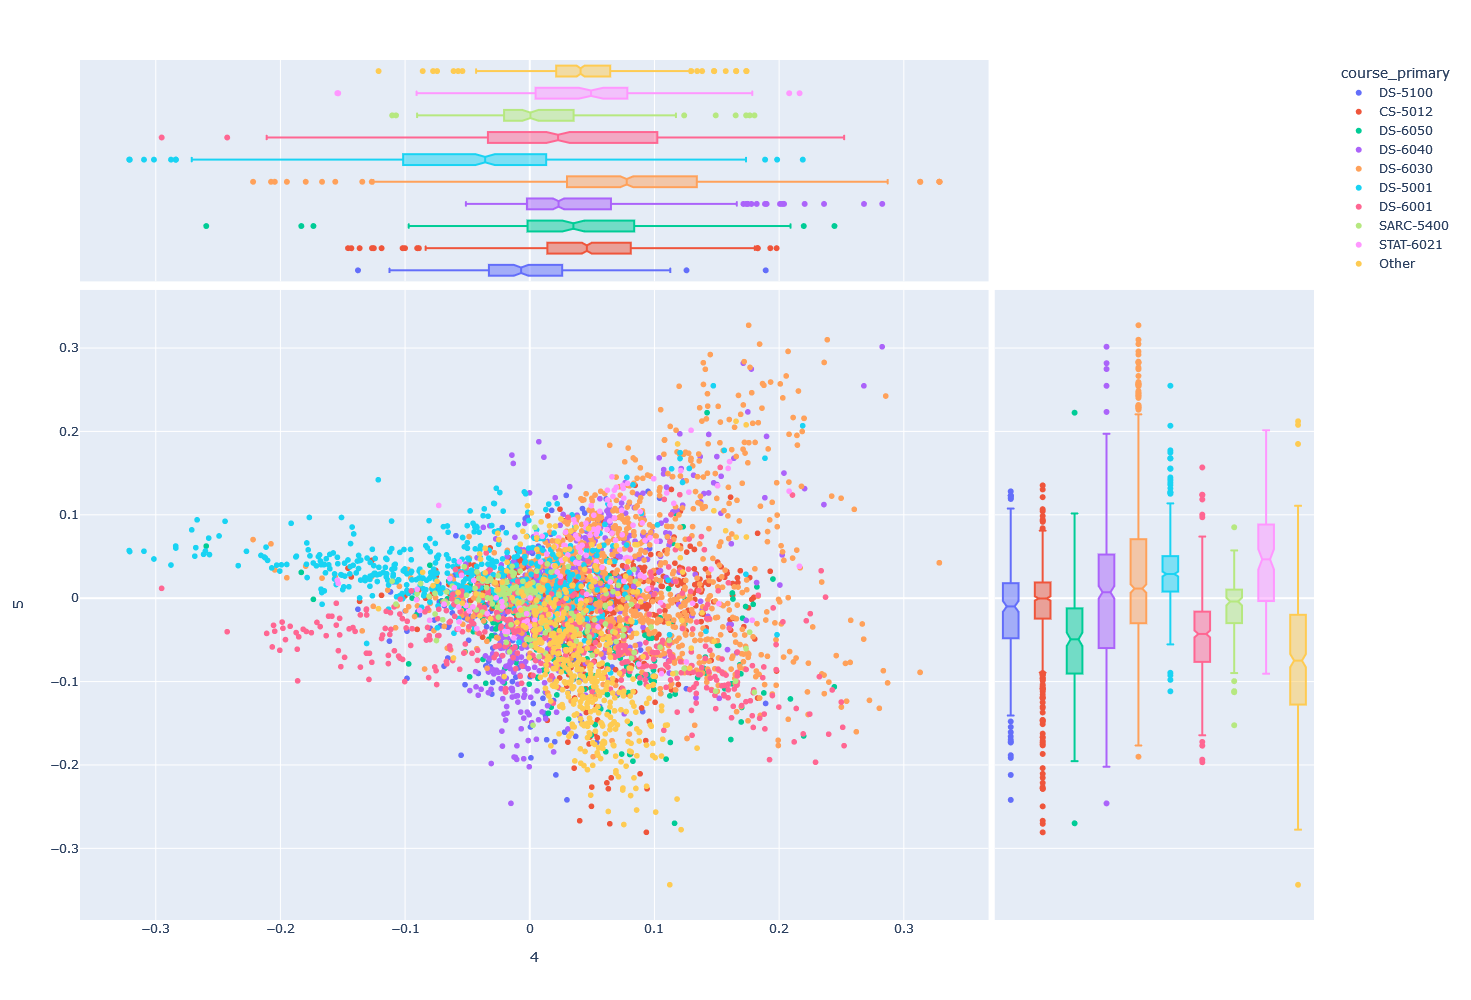

In [91]:
px.scatter(DOC, 4, 5, 
           color='course_primary', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

## Components by category (cat_1)

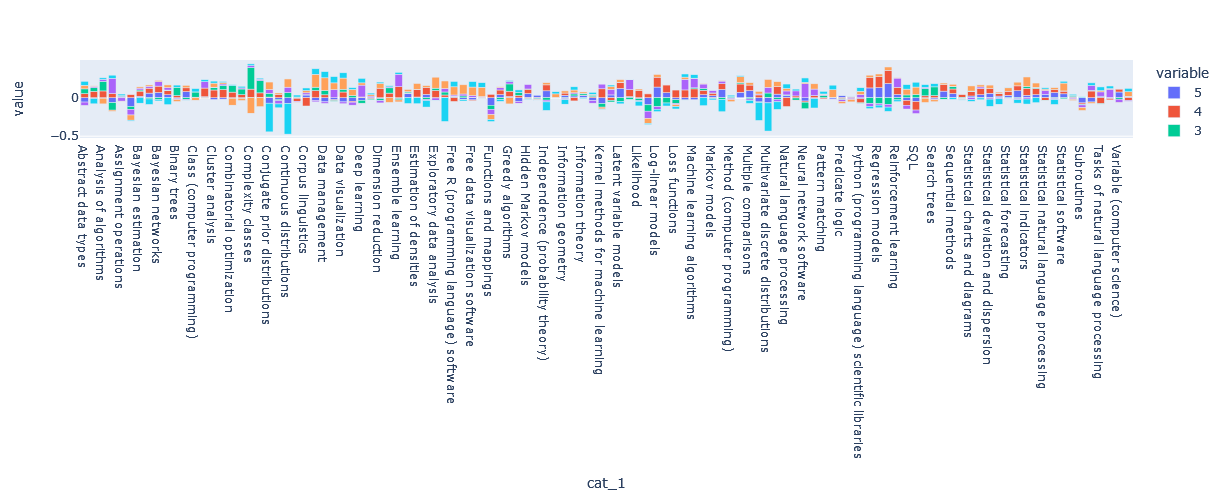

In [92]:
px.bar(DOC.groupby('cat_1')[pc_ids].mean(), width=800, height=500)



## Components by primary course

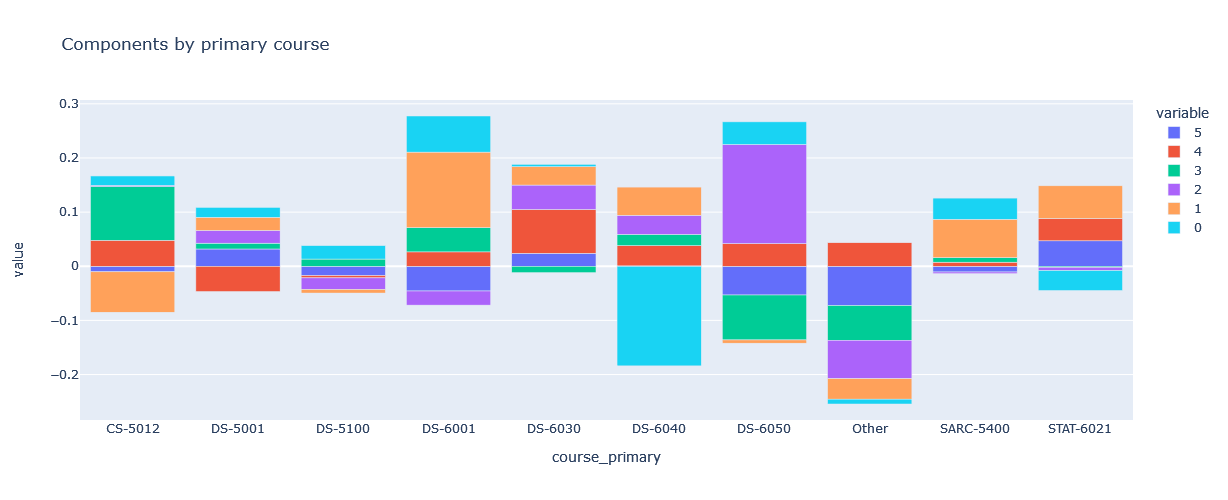

In [102]:
px.bar(DOC.groupby('course_primary')[pc_ids].mean(), width=800, height=500, title = 'Components by primary course')

# Loading Scatterplots

In [96]:
X = L.join(VOCAB.loc[SIGS], how='inner')

In [97]:
X.index

Index(['ability', 'able', 'absolute', 'abstract', 'access', 'according',
       'account', 'accuracy', 'achieve', 'achieved',
       ...
       'word', 'words', 'work', 'working', 'works', 'world', 'worst',
       'written', 'years', 'zero'],
      dtype='object', name='term_str', length=1000)

In [98]:
X

0         1             2         3         4  \
term_str                                                                    
ability          8.201027e-03  0.011709  2.066823e-03  0.004669 -0.001711   
able             6.823705e-03  0.003488  9.069097e-03  0.003002  0.004239   
absolute        -8.582655e-03  0.001667 -7.903870e-03 -0.005261  0.005262   
abstract         6.519821e-03  0.001506 -9.906977e-03  0.004359  0.000783   
access           2.038343e-02  0.022907 -3.921054e-03  0.026133 -0.007446   
according        1.516411e-03  0.001488  4.122287e-03  0.005965 -0.005483   
account          8.278358e-05  0.003963 -8.211751e-05 -0.005107  0.008818   
accuracy         1.790174e-03  0.000684  6.228216e-03 -0.002747  0.009138   
achieve          3.236335e-03  0.000148  1.424451e-03  0.001009  0.000895   
achieved         2.720545e-03 -0.000608  2.989768e-03 -0.001051 -0.001262   
action           3.766528e-03 -0.003980  1.003990e-02 -0.000402  0.001648   
actual          -1.538317e-03  0.003364 -1.189420e-03 -0.000825  0.003857   
actually         1.935860e-03  0.002502 -4.223466e-03  0.000044  0.002785   
added            4.012457e-03  0.002132 -3.186297e-03 -0.000101 -0.005281   
adding           3.699956e-03  0.002142 -4.312030e-03  0.003709  0.003872   
addition         1.670292e-03 -0.002804 -1.307654e-02 -0.003336 -0.002253   
additional       4.089201e-03  0.000133 -1.202525e-03  0.003979 -0.002914   
address          6.719163e-03  0.004546 -5.875667e-03  0.002815 -0.004072   
advanced         7.660338e-03  0.009339  6.284284e-03 -0.001665 -0.007027   
advantage        1.849330e-03  0.004118  2.982540e-03  0.003031  0.005354   
aims             4.686851e-03  0.002984  4.187560e-03 -0.002625  0.002202   
al              -2.286718e-04 -0.000270  8.586910e-03 -0.005199  0.001764   
algebra          6.696481e-05 -0.041018 -6.593424e-02 -0.066575  0.000204   
algebraic       -2.592339e-03 -0.019102 -2.303305e-02 -0.018344  0.001433   
algorithm        4.250888e-02 -0.140702  1.339851e-01  0.186384  0.156518   
algorithms       3.210478e-02 -0.047092  8.677570e-02  0.067250  0.065588   
allow            5.841119e-03  0.004088 -1.956233e-04  0.000816 -0.005330   
allowing         2.722277e-03  0.002360 -1.408189e-03 -0.002272  0.000855   
allows           1.222120e-02  0.012789 -3.081759e-04 -0.000370 -0.009784   
alternative     -3.972027e-03  0.004364  2.624537e-03 -0.004470  0.004986   
american         3.825080e-03  0.002374 -1.732750e-03 -0.000289 -0.014510   
analysis         2.377137e-02  0.102784 -5.478932e-02 -0.068977  0.115800   
analytics        2.271151e-02  0.044990  3.203633e-03  0.009899 -0.007870   
analyze          6.279685e-03  0.007584  3.171779e-03  0.000770 -0.004742   
analyzing        3.522423e-03  0.012279  9.690191e-04  0.002429  0.007876   
answer           3.751535e-03 -0.018000  3.355687e-03  0.031737  0.007209   
appear           6.658936e-04  0.005904 -3.446244e-03  0.000614  0.002080   
applicable       6.814621e-04  0.000931  4.941673e-03 -0.000900  0.002409   
application      1.519639e-02  0.021631  5.873425e-03 -0.000918 -0.014179   
applications     1.411637e-02  0.021585  1.667300e-02 -0.000173 -0.006669   
applied         -9.397572e-04  0.002181  7.562895e-03 -0.009056  0.019092   
applies         -2.224198e-03 -0.001069  6.627882e-04 -0.001852  0.000380   
applying         1.050088e-03 -0.005727  4.753872e-03 -0.007282  0.002498   
approach         3.387069e-03  0.008998  1.146731e-02 -0.005496  0.016288   
approaches       1.423047e-03  0.005034  1.494224e-02 -0.009220  0.003970   
appropriate     -3.552991e-03  0.001927 -1.663487e-03 -0.000503  0.005424   
approximate     -4.583532e-03 -0.003653  4.958582e-03  0.004342  0.008544   
approximation   -2.827042e-03 -0.017256  7.454142e-03  0.004853  0.027728   
arbitrary        3.244757e-04 -0.004521 -4.184101e-03 -0.004951  0.002866   
architecture     1.608116e-02  0.028622  1.342753e-02 -0.001473 -0.003917   
area             5.60023

## PC 0 and 1

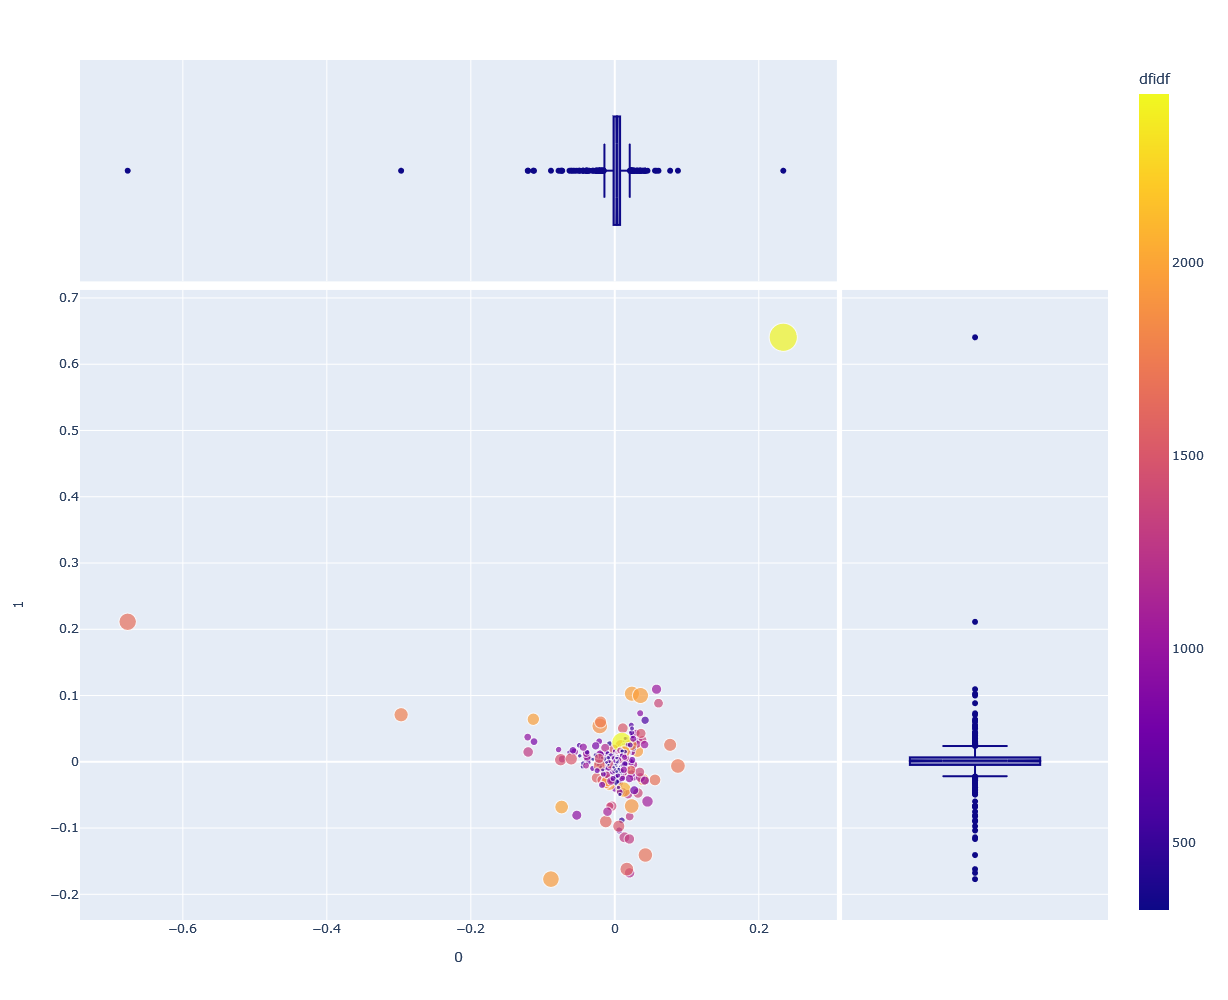

In [99]:
px.scatter(X, 0, 1, size=X.n, color=X.dfidf,
           hover_name=X.index, 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

# Save

In [ ]:
#DCM.to_csv("PCA-DCM.csv")

In [ ]:
#L.to_csv("PCA-Loadings.csv")

In [ ]:
#COMPINF.to_csv("PCA-ComponentInfo.csv")